In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Useful Resources

- https://msnews.github.io/#about-mind - data source
- https://github.com/microsoft/recommenders - implementation and practice of several existing news recommendation methods
- https://www.kaggle.com/datasets/arashnic/mind-news-dataset - dataset on kaggle

# Set Up

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import string
import json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from textblob import TextBlob
from wordcloud import WordCloud

# News Dataset

### Reading Data & Initial Info

In [3]:
# For google colab
df_news = pd.read_csv("/content/news.tsv", header=None, sep='\t')
df_news.columns = ['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']

In [4]:
df_news.shape

(51282, 8)

In [5]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_id         51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


###**news.tsv Variables**

- **article_id**: A unique identifier for each news article.
- **category**: The general genre or topic of the article (e.g., sports, entertainment).
- **subcategory**: A more detailed classification within the category.
- **title**: The headline or title of the news article.
- **abstract**: A brief summary of the article's content.
- **url**: A hyperlink to the full article online.
- **title_entities**: Important entities identified from the article's title, with links to their corresponding WikiData pages.
- **abstract_entities**: Similar to `title_entities`, but extracted from the abstract of the article.




In [6]:
df_news.head(5)

,article_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [9]:
df_news.isna().sum()

,0
article_id,0
category,0
subcategory,0
title,0
abstract,2666
url,0
title_entities,3
abstract_entities,4


### Categories & Subcategories
- Category & Subcategory counts
- Categories by popularity
- Category & Subcategory distribution
- Top subcategories (for top 5 categories)
- Most common words per category
- Most common bigram per category

In [10]:
# Number of categories
df_news['category'].nunique()

17

In [11]:
# Number of articles per category
df_news.groupby('category')['subcategory'].count().sort_values(ascending=False)

,subcategory
category,
news,15774
sports,14510
finance,3107
foodanddrink,2551
lifestyle,2479
travel,2350
video,2068
weather,2048
health,1885


In [14]:
# Get the categories in order of popularity
category_order = [x for x, count in sorted(Counter(df_news['category']).items(), key=lambda x: -x[1])]

# Create a DataFrame with category counts
category_counts = df_news['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values('category', key=lambda x: [category_order.index(c) for c in x])

# Create the count plot using Plotly
fig = px.bar(category_counts, x='category', y='count', title='Category Counts')
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': category_order})

# Display the plot
fig.show()

In [15]:
c=df_news[['category','subcategory']].value_counts()

index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

distribution_df=pd.DataFrame(columns=['category','subcategory','values'])
distribution_df['category']=index[:,0]
distribution_df['subcategory']=index[:,1]
distribution_df['values']=c.values

px.bar(data_frame=distribution_df,x='category',y='values',color='subcategory')

####top 5 bigram words in every category


In [18]:
# Import necessary libraries
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import nltk

# Ensure stopwords are available
nltk.download('stopwords')

# Define the set of English stopwords
stopword_list = set(stopwords.words('english'))

# Group the dataset by category
categories_grouped = df_news.groupby('category')

# Process each category to find top 5 bi-grams
for category_label, data_group in categories_grouped:
    # Combine all titles within the category into a single string
    all_titles_combined = ' '.join(data_group['title'])

    # Tokenize words and filter out stopwords
    filtered_tokens = [word.strip(' "\'') for word in all_titles_combined.split()
                       if word.lower() not in stopword_list and word != '-']

    # Generate bi-grams from filtered tokens
    bi_grams_list = list(nltk.bigrams(filtered_tokens))

    # Count occurrences of each bi-gram
    bi_gram_frequencies = Counter(bi_grams_list)

    # Get the top 5 most frequent bi-grams
    top_five_bi_grams = bi_gram_frequencies.most_common(5)

    # Print the results
    print(f"Category: {category_label}")
    for bi_gram, frequency in top_five_bi_grams:
        print(f"{' '.join(bi_gram)} ({frequency})")
    print()


autos:
Ford Mustang (23)
2020 Ford (19)
Mustang Shelby (13)
Shelby GT500 (13)
crash involving (13)

entertainment:
plus news (24)
People's Choice (22)
Choice Awards (16)
Kylie Jenner (9)
2019 People's (8)

finance:
Apartments rent (42)
get you? (42)
Social Security (18)
737 Max (17)
right now? (14)

foodanddrink:
Thanksgiving Recipes (26)
Every State (23)
Thanksgiving Dinner (21)
Veterans Day (19)
Trader Joe's (18)

health:
Weight Loss (29)
Lose Weight (19)
Breast Cancer (18)
breast cancer (13)
Need Know (11)

kids:
Americans Use (1)
Use Fahrenheit (1)
Fahrenheit Instead (1)
Instead Celsius (1)
Celsius Take (1)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lifestyle:
Meghan Markle (57)
Kate Middleton (34)
Prince Harry (31)
Veterans Day (19)
Zodiac Sign (16)

middleeast:
Saudi says (1)
says Baghdadi (1)
Baghdadi distorted (1)
distorted image (1)
image Islam, (1)

movies:
Jennifer Aniston (11)
Box Office (10)
Kevin Hart (9)
Charlize Theron (9)
Star Wars (8)

music:
CMA Awards (29)
Taylor Swift (22)
Kanye West (16)
Elton John (15)
Carrie Underwood (14)

news:
police say (201)
White House (124)
impeachment inquiry (106)
Apartments rent (82)
get you? (82)

northamerica:
Republicans floated (1)
floated 17 (1)
17 different (1)
different defenses (1)
defenses Trump's (1)

sports:
World Series (235)
Week 10 (141)
Tom Brady (101)
high school (99)
Week 9 (95)

travel:
Veterans Day (38)
New York (21)
American Airlines (19)
St. Louis (14)
Day Parade (14)

tv:
Jennifer Aniston (15)
Kim Kardashian (14)
TV shows (13)
Felicity Huffman (13)
Joe Giudice (11)

video:
impeachment inquiry (36)
impeachment hearings (35)
impeachment hearing (24)
public impeachm

In [20]:
# most popular titles per category
df_news.groupby('category')['title'].value_counts().nlargest(10)

category      title                                                                        
news          Photos of the Day                                                                15
lifestyle     Look of the Day                                                                  14
sports        Video appears to show Astros stealing signs against Danny Farquhar                6
foodanddrink  Thanksgiving Recipe Searches Reveal Florida's Tastes                              5
music         New and upcoming releases                                                         5
news          Microsoft vows to 'honor' California's sweeping privacy law across entire US      5
sports        Friday's Scores                                                                   5
              Yankees make crucial error against Jose Altuve in 9th inning of ALCS clincher     5
              Yu Darvish sends hilarious tweet about Astros cheating scandal                    5
video         Morning news briefing from CNN                                                    5
Name: count, dtype: int64

#### Word Clouds (from titles) per Category

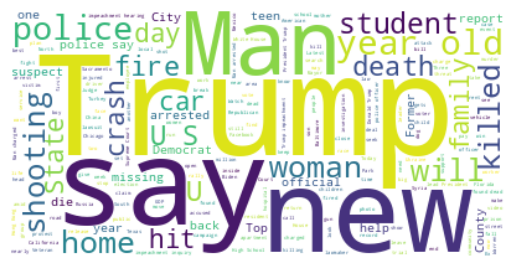

In [25]:
# news category
text=' '
for i in df_news[df_news['category']=='news']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

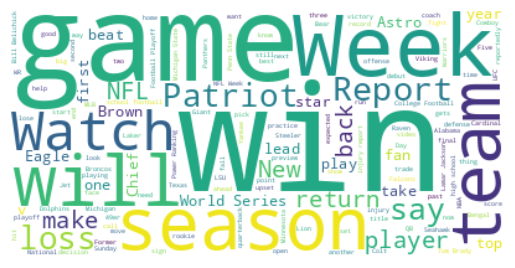

In [26]:
# sports category
text=' '
for i in df_news[df_news['category']=='sports']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

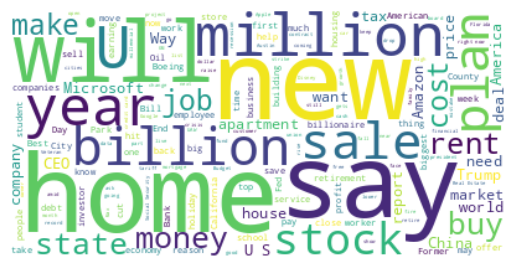

In [27]:
# finance category
text=' '
for i in df_news[df_news['category']=='finance']['title']:
    text+=i+' '

# Make the figure
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### Title Entities
- Most & least common entities

In [33]:
# define function to extract any metric from any of the entities columns

def entities(df, col_number, metric):
    entities = df.iloc[:, col_number]
    entities = entities.dropna()

    labels = []

    for entity in entities:
        entity = json.loads(entity)

        for dictionary in entity:
            labels.append(dictionary[metric])

    return labels

In [34]:
title_labels = entities(df_news, 6, 'Label')

In [35]:
# find 10 most and least popular labels
title_label_counter = Counter(title_labels)

bottom_10_title_labels = title_label_counter.most_common()[::-1][:10]
top_10_title_labels = title_label_counter.most_common(10)

In [36]:
top_10_title_labels

[('Donald Trump', 1501),
 ('National Football League', 510),
 ('United States', 398),
 ('New England Patriots', 392),
 ('Houston Astros', 369),
 ('California', 339),
 ('Republican Party (United States)', 289),
 ('Democratic Party (United States)', 273),
 ('Florida', 265),
 ('Ukraine', 263)]

# Behaviours Dataset

### Reading Data & Initial Info

In [39]:
df_behaviors = pd.read_csv("/content/behaviors.tsv", header=None, sep='\t')
df_behaviors.columns = ['impression_id', 'user_id', 'timestamp', 'history', 'impressions']

**behaviors.tsv variables**
- impression_id: unique ID of an impression
- user_id: anonymous ID of a user
- timestamp: impression time with format "MM/DD/YYYY HH:MM:SS AM/PM"
- history: news click history (ID list of clicked news) of this user before this impression. The clicked news articles are ordered by time.
- impressions: list of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click). The orders of news in a impressions have been shuffled.

_source: https://www.kaggle.com/datasets/arashnic/mind-news-dataset_

In [40]:
df_behaviors.shape

(156965, 5)

In [41]:
df_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   timestamp      156965 non-null  object
 3   history        153727 non-null  object
 4   impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [43]:
df_behaviors.head(5)

,impression_id,user_id,timestamp,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [44]:
# convert timestamp to date time
df_behaviors['timestamp'] = pd.to_datetime(df_behaviors['timestamp'])

In [45]:
print(df_behaviors['timestamp'].min())
print(df_behaviors['timestamp'].max())

2019-11-09 00:00:19
2019-11-14 23:59:13


In [46]:
# unique number of user IDs
df_behaviors['user_id'].nunique()

50000

In [47]:
# unique number of histories
df_behaviors['history'].nunique()

48868

### NA Values

In [48]:
df_behaviors.isna().sum()

,0
impression_id,0
user_id,0
timestamp,0
history,3238
impressions,0


In [50]:
df_behaviors.head(5)

,impression_id,user_id,timestamp,history,impressions
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,2019-11-12 18:11:30,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,2019-11-14 07:01:48,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,2019-11-11 05:28:05,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,2019-11-12 16:11:21,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


### Time Series

In [51]:
df_behaviors['hour'] = pd.to_datetime(df_behaviors['timestamp']).dt.hour
hourly_counts = df_behaviors['hour'].value_counts().sort_index()

In [52]:
fig = px.bar(x=hourly_counts.index, y=hourly_counts.values)
fig.update_layout(
    xaxis_title="Hour of the day",
    yaxis_title="Total number of rows",
    title="Total Number of Rows per Hour"
)
fig.show()


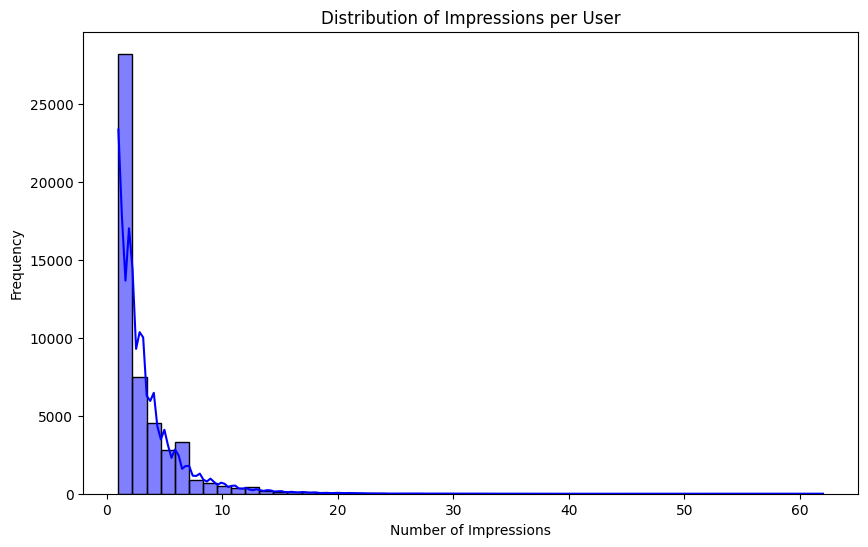

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count impressions per user
user_impression_count = df_behaviors['user_id'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(user_impression_count, bins=50, kde=True, color='blue')
plt.title('Distribution of Impressions per User')
plt.xlabel('Number of Impressions')
plt.ylabel('Frequency')
plt.show()


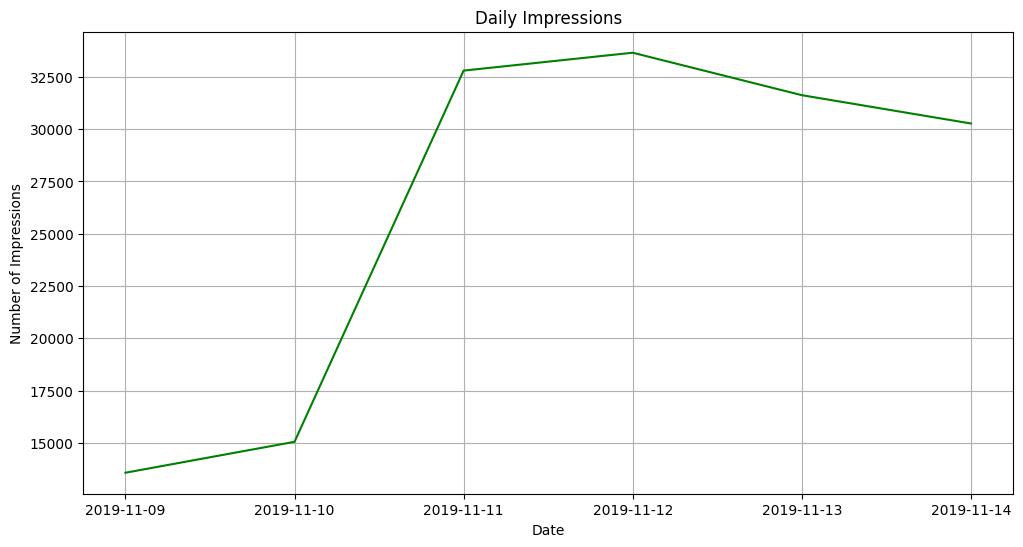

In [61]:
# Convert timestamp to datetime
df_behaviors['timestamp'] = pd.to_datetime(df_behaviors['timestamp'])

# Group by date and count impressions
time_distribution = df_behaviors['timestamp'].dt.date.value_counts().sort_index()

# Plot the time series
plt.figure(figsize=(12, 6))
time_distribution.plot(kind='line', color='green')
plt.title('Daily Impressions')
plt.xlabel('Date')
plt.ylabel('Number of Impressions')
plt.grid()
plt.show()


In [53]:
daily_counts = df_behaviors.resample('H', on='timestamp').size()

# Create the time series plot using Plotly
fig = px.line(x=daily_counts.index, y=daily_counts.values)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Count of rows",
    title="Impressions over Time"
)
fig.show()

<ipython-input-53-f55b766e6496>:1: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



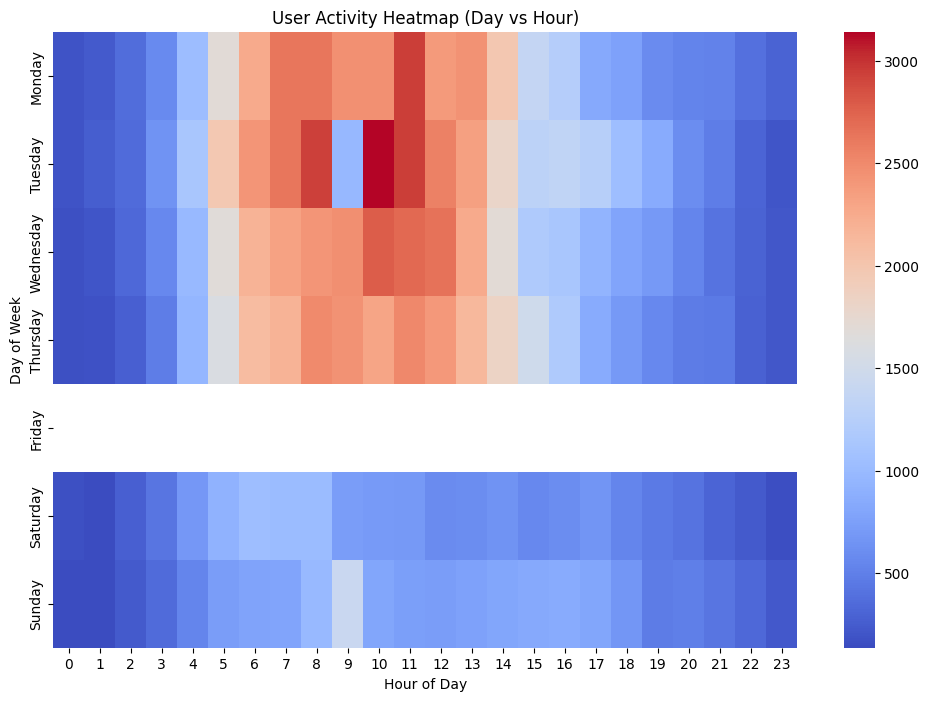

In [63]:
# hour and day of week from timestamp
df_behaviors['hour'] = df_behaviors['timestamp'].dt.hour
df_behaviors['day_of_week'] = df_behaviors['timestamp'].dt.day_name()

# Pivot table for heatmap
heatmap_data = df_behaviors.pivot_table(index='day_of_week', columns='hour', values='impression_id', aggfunc='count').fillna(0)

# Reorder days for the heatmap
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt='g')
plt.title('User Activity Heatmap (Day vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [54]:
# Number of users with empty history
print('number of empty history users: ', df_behaviors.loc[df_behaviors['history'] == 0].shape[0])

number of empty history users:  0


### Unique Users

In [55]:
# User with max number of rows
df_behaviors.groupby('user_id').size().max()

62

In [56]:
# Count number of articles in the history column in each row
df_behaviors['history_number'] = df_behaviors['history'].apply(lambda x: len(str(x).split()))

# Find the maximum number of articles in the history column and its count
print('Max number of articles in history:', df_behaviors['history_number'].max())
print('Number of rows with', df_behaviors['history_number'].max(), 'rows:', df_behaviors[df_behaviors['history_number'] == df_behaviors['history_number'].max()].shape[0])

Max number of articles in history: 558
Number of rows with 558 rows: 34


In [57]:
# Create a histogram trace
histogram_trace = go.Histogram(
    x=df_behaviors['history_number'],
    nbinsx=200  # Number of bins for the histogram
)

# Create the layout for the histogram
layout = go.Layout(
    title='Histogram of History Numbers',
    xaxis=dict(title='History Number'),
    yaxis=dict(title='Count')
)

# Create the Figure object
fig = go.Figure(data=[histogram_trace], layout=layout)

fig.show()

In [58]:
# convert history to string
df_behaviors['history'] = df_behaviors['history'].astype(str)

# group by user and concatente histories
grouped_by_user = df_behaviors.groupby('user_id')['history'].agg(lambda x: ' '.join(x))

# calculate max history articles per user
print(grouped_by_user.apply(lambda x: len(str(x).split(' '))).max())

18972


### Findings:
- 3238 NA values in 'history' column
- Data on 50000 users
- Data on 48868 unique histories
